[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/deJong_Azimi/rainshaft.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/deJong_Azimi/rainshaft.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/deJong_Azimi/rainshaft.ipynb)

#### Derived from the precipitation case of Fig. 1 from Shipway & Hill 2012, but with no condensation/evaporation (collisions only). For further information, see Shipway_Hill_2012 example.

**NOTES**: 
- constant momentum profile rather than constant velocity profile is used herein
- sedimentation and collisions are the only active dynamics
- pressure at z=0 not given in the paper, assumed (see settings.py)
- domain extended below z=0 to mimic particle inflow via updraft

In [1]:
import os, sys
if sys.platform != 'darwin': # TODO #1749
    os.environ['NUMBA_THREADING_LAYER'] = 'omp'  # PySDM and PyMPDATA are incompatible with TBB threads
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples', 'PySDM')

In [13]:
from PySDM_examples.Shipway_and_Hill_2012 import plot, Simulation
from PySDM_examples.deJong_Azimi import Settings1D, cloudy_data
from open_atmos_jupyter_utils import show_plot
from PySDM.physics import si, in_unit
from PySDM.exporters import NetCDFExporter_1d
from matplotlib import pyplot

## Collisions Only Test Case

In [3]:
common_params = {
    "n_sd_per_gridbox": 128,
    "dt": 10 * si.s,
    "dz": 50 * si.m,
    "particles_per_volume_STP": 10 / si.cm**3,
    "t_max": 1000 * si.s
}
output = {}
settings = {}
simulation = {}
for rho_times_w in (
    0 * si.kg/si.m**3 * si.m/si.s,
):
    key = f"rhow={rho_times_w}"
    settings[key] = Settings1D(
        **common_params,
        rho_times_w_1=rho_times_w,
    )
    simulation[key] = Simulation(settings[key])
    output[key] = simulation[key].run().products

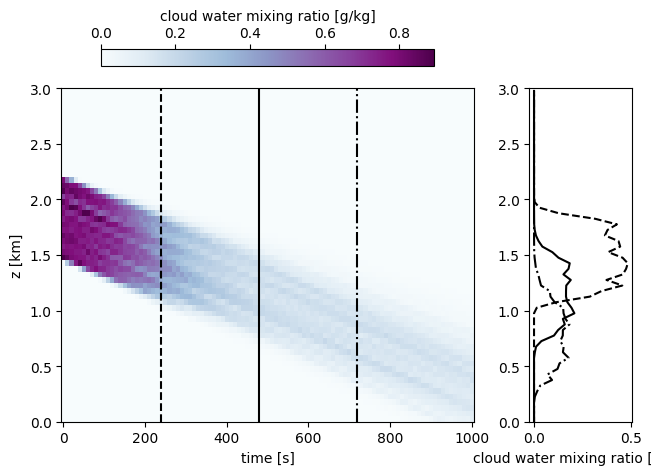

HTML(value="<a href='./qc_rhow=0.pdf' target='_blank'>./qc_rhow=0.pdf</a><br>")

In [4]:
for rho_times_w in (0,):
    plot(var='cloud water mixing ratio', qlabel='cloud water mixing ratio [g/kg]', fname=f'qc_rhow={rho_times_w}.pdf',
            output=output[f'rhow={rho_times_w}.0'],
            line = {0: ":", 4: "--", 8: "-", 12: "-."})

In [5]:
output[f'rhow={rho_times_w}.0']['nc'].max()

9198167.88

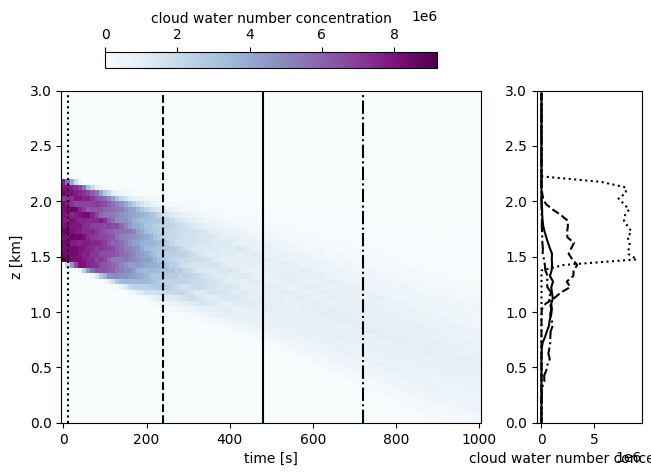

HTML(value="<a href='./nc_rhow=0.pdf' target='_blank'>./nc_rhow=0.pdf</a><br>")

In [6]:
for rho_times_w in (0,):
    plot(var='nc', qlabel='cloud water number concentration', fname=f'nc_rhow={rho_times_w}.pdf',
            output=output[f'rhow={rho_times_w}.0'],
            line = {0.01: ":", 4: "--", 8: "-", 12: "-."})

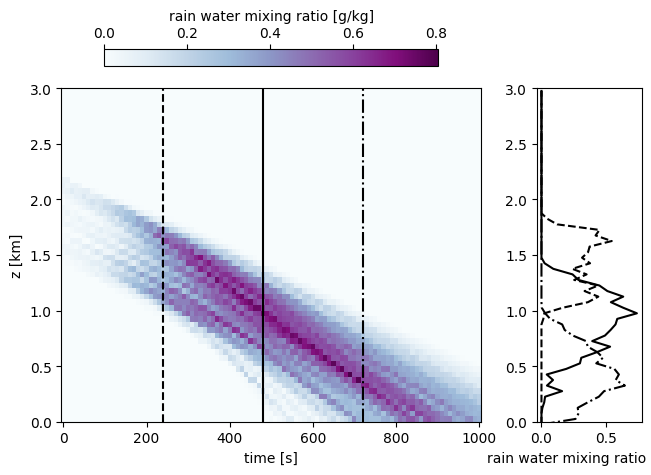

HTML(value="<a href='./qr_rhow=0.pdf' target='_blank'>./qr_rhow=0.pdf</a><br>")

In [7]:
p = True
for rho_times_w in (0,):
    plot(var='rain water mixing ratio', qlabel='rain water mixing ratio [g/kg]', fname=f'qr_rhow={rho_times_w}.pdf',
         output=output[f'rhow={rho_times_w}.0'],
         line = {0: ":", 4: "--", 8: "-", 12: "-."})

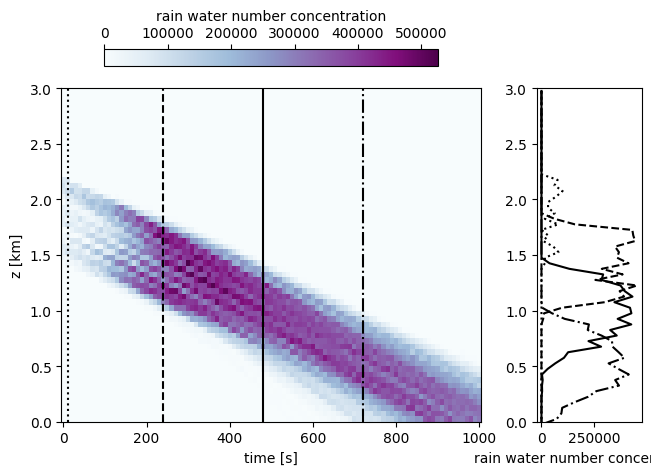

HTML(value="<a href='./nr_rhow=0.pdf' target='_blank'>./nr_rhow=0.pdf</a><br>")

In [8]:
for rho_times_w in (0,):
    plot(var='nr', qlabel='rain water number concentration', fname=f'nr_rhow={rho_times_w}.pdf',
            output=output[f'rhow={rho_times_w}.0'],
            line = {0.01: ":", 4: "--", 8: "-", 12: "-."})

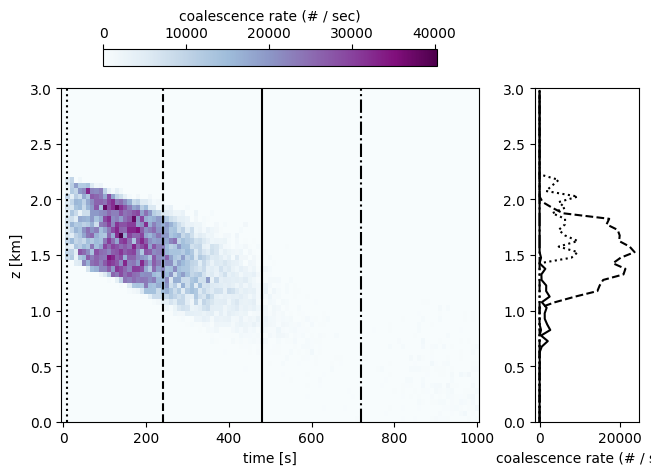

HTML(value="<a href='./coal_rhow=0.pdf' target='_blank'>./coal_rhow=0.pdf</a><br>")

In [9]:
p = True
for rho_times_w in (0,):
    plot(var='coalescence_rate', qlabel='coalescence rate (# / sec)', fname=f'coal_rhow={rho_times_w}.pdf',
         output=output[f'rhow={rho_times_w}.0'],
         line = {0.01: ":", 4: "--", 8: "-", 12: "-."})

## Comparisons

In [10]:
p = True
for rho_times_w in (0,):
    key = f"rhow={rho_times_w}.0"
    filename = 'products_' + key + 'collisions.nc'
    nc_exporter = NetCDFExporter_1d(output[key], settings[key], simulation[key], filename)
    nc_exporter.run()

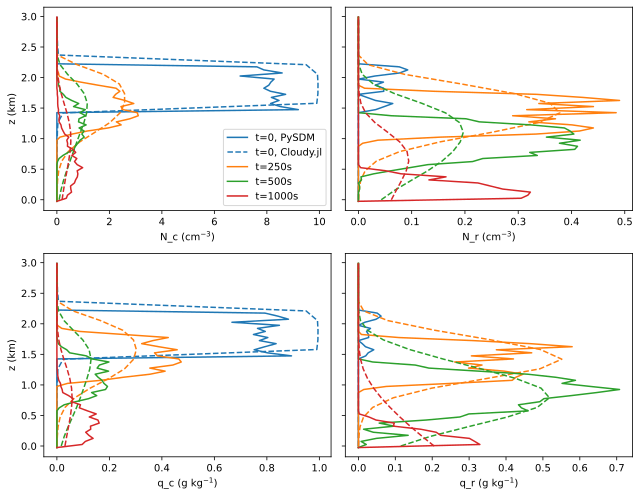

HTML(value="<a href='./rainshaft.pdf' target='_blank'>./rainshaft.pdf</a><br>")

In [14]:
plt_times = [0, 250, 500, 1000]
dt = common_params["dt"]
dz = common_params["dz"] / 1000

(fig, ax) = pyplot.subplots(nrows=2, ncols=2, sharey=True, figsize=(9,7), tight_layout=True)
for (j,t) in enumerate(plt_times):
    it = int(t / dt)
    profiles = output[f'rhow={rho_times_w}.0']
    nc = profiles['nc'][:,it]
    nr = profiles['nr'][:,it]
    qc_g_kg = profiles['cloud water mixing ratio'][:,it]
    qr_g_kg = profiles['rain water mixing ratio'][:,it]

    if j == 0:
        lbl = 't=0, PySDM'
        lbl2 = 't=0, Cloudy.jl'
    else:
        lbl = 't='+str(t)+'s'
        lbl2 = '_'
    line = ax[0][0].plot(
        in_unit(nc, si.cm**-3),
        in_unit(profiles['z'], si.km),
        label=lbl
    )
    ax[0][0].plot(
        cloudy_data.NC[j],
        cloudy_data.Z,
        '--',
        color=line[-1].get_color(),
        label=lbl2
    )
    line = ax[0][1].plot(
        in_unit(nr, si.cm**-3),
        in_unit(profiles['z'], si.km)
    )
    ax[0][1].plot(
        cloudy_data.NR[j],
        cloudy_data.Z,
        '--',
        color=line[-1].get_color()
    )
    line = ax[1][0].plot(
        qc_g_kg,
        in_unit(profiles['z'], si.km)
    )
    ax[1][0].plot(
        cloudy_data.QC[j],
        cloudy_data.Z,
        '--',
        color=line[-1].get_color()
    )
    line = ax[1][1].plot(
        qr_g_kg,
        in_unit(profiles['z'], si.km)
    )
    ax[1][1].plot(
        cloudy_data.QR[j],
        cloudy_data.Z,
        '--',
        color=line[-1].get_color()
    )

ax[0][0].set_xlabel('N_c (cm$^{-3}$)')
ax[0][0].set_ylabel('z (km)')
ax[0][0].legend()
ax[0][1].set_xlabel('N_r (cm$^{-3}$)')
ax[1][0].set_xlabel('q_c (g kg$^{-1}$)')
ax[1][0].set_ylabel('z (km)')
ax[1][1].set_xlabel('q_r (g kg$^{-1}$)')

show_plot('rainshaft.pdf')